## 分类

In [1]:
from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier

iris = load_iris()
X = iris.data[:, 2:] # petal length and width
y = iris.target

tree_clf = DecisionTreeClassifier(max_depth=2)
tree_clf.fit(X, y)

DecisionTreeClassifier(max_depth=2)

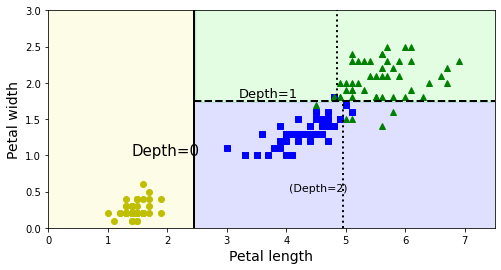

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

def plot_decision_boundary(clf, X, y, axes=[0, 7.5, 0, 3], iris=True, legend=False, plot_training=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    if not iris:
        custom_cmap2 = ListedColormap(['#7d7d58','#4c4c7f','#507d50'])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    if plot_training:
        plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", label="Iris setosa")
        plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", label="Iris versicolor")
        plt.plot(X[:, 0][y==2], X[:, 1][y==2], "g^", label="Iris virginica")
        plt.axis(axes)
    if iris:
        plt.xlabel("Petal length", fontsize=14)
        plt.ylabel("Petal width", fontsize=14)
    else:
        plt.xlabel(r"$x_1$", fontsize=18)
        plt.ylabel(r"$x_2$", fontsize=18, rotation=0)
    if legend:
        plt.legend(loc="lower right", fontsize=14)

plt.figure(figsize=(8, 4))
plot_decision_boundary(tree_clf, X, y)
plt.plot([2.45, 2.45], [0, 3], "k-", linewidth=2)
plt.plot([2.45, 7.5], [1.75, 1.75], "k--", linewidth=2)
plt.plot([4.95, 4.95], [0, 1.75], "k:", linewidth=2)
plt.plot([4.85, 4.85], [1.75, 3], "k:", linewidth=2)
plt.text(1.40, 1.0, "Depth=0", fontsize=15)
plt.text(3.2, 1.80, "Depth=1", fontsize=13)
plt.text(4.05, 0.5, "(Depth=2)", fontsize=11)

plt.show()

上图中，
- 根节点的决策边界是：花瓣长度 = 2.45
- 深度为1的右边节点的决策边界是：花瓣宽度 = 1.75

In [3]:
import os
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "decision_trees"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)
IMAGES_PATH

'.\\images\\decision_trees'

In [4]:
## 导出训练好的决策树模型可视化图片

# from sklearn.tree import export_graphviz
#
# export_graphviz(
#         tree_clf,
#         out_file=os.path.join(IMAGES_PATH, "iris_tree.dot"),
#         feature_names=iris.feature_names[2:],
#         class_names=iris.target_names,
#         rounded=True,
#         filled=True
# )

可视化决策树图片解释：
- 根节点查看花瓣长度是否小于2.45
  - 如果是，则移动到左子节点，并判断为setosa
  - 如果不是，则移动到右子节点，查看花瓣宽度是否小于1.75
    - 如果是，则判断为versicolor
    - 如果不是，则判断为verginica

注意：
- samples属性表示该节点所用到的样本数量
- value属性表示该节点属于每个类别的样本数量
- gini属性衡量不纯度，G_i = 1 - \sum_{k=1}^np_{i,k}^2，如：1 - (0/54)^2 - (49/54)^2 - (5/54)^2 = 0.618
- 也可使用熵来衡量不纯度，如：- 49/54 log_2(49/54) - 5/54 log_2(5/54) = 0.445
- 训练决策树模型不需要进行特征缩放


决策树算法：

- CART（Classification and Regression Tree）算法：仅生成二叉树，非叶节点永远只有两个子节点（sklearn采用这种算法）
    - 选择单个特征k和阈值t_k将训练集分成两个子集，两个子集重复同样的过程
    - 选择的（k, t_k）使得两个子集的加权不纯度最小
    - 权重为子集的样本数量占比
    - 这种每层重复分裂的过程是一种贪心算法，通常能得到一个相当不错的解，但不保证是最优解
- ID3算法：节点可以拥有两个以上的子节点

决策树也可预测不同分类的概率：

例如：花瓣长5cm，宽1.5cm。P(versicolor) = 49/54 = 0.907；P(verginica) = 5/54 = 0.093；

In [5]:
# 花瓣长5cm，宽1.5cm，属于不同分类的概率
tree_clf.predict_proba([[5, 1.5]])

array([[0.        , 0.90740741, 0.09259259]])

In [6]:
# 花瓣长5cm，宽1.5cm，属于哪种分类
tree_clf.predict([[5, 1.5]])

array([1])

正则化

- 决策树极少对数据作出假设（线性回归假设数据是线性的），因此树的结构会随着训练集的变化严密拟合，从而发生过拟合
- 这种模型也叫非参数模型，意思就是在训练之前没有确定参数的数量，而参数模型（如线性回归）预先设定好参数数量，自由度受限
- 降低决策树自由度是一种正则化，可以控制：
- 树的最大深度、分裂节点前最小样本量、叶子节点最小样本量、最大叶子节点数量
- 另一种方法：先不加约束地训练模型，再对叶子节点进行剪枝
    - 如果一个节点的子节点全为叶子节点，除非这个节点表示的纯度提升在统计上显著，否则可以删除这个节点
    - 可以使用卡方测试，p值为0.05

不稳定性
- 决策树喜欢正交的边界，所有分割都垂直于轴
- 对训练集进行旋转将变得很敏感

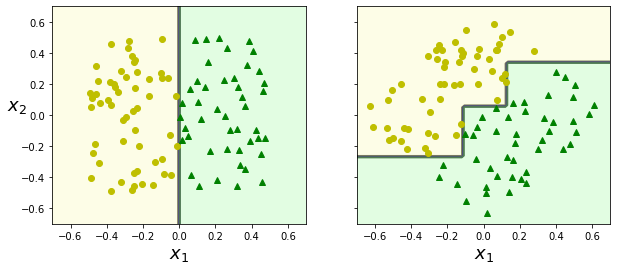

In [7]:
np.random.seed(6)
Xs = np.random.rand(100, 2) - 0.5
ys = (Xs[:, 0] > 0).astype(np.float32) * 2

angle = np.pi / 4
rotation_matrix = np.array([[np.cos(angle), -np.sin(angle)], [np.sin(angle), np.cos(angle)]])
Xsr = Xs.dot(rotation_matrix)

tree_clf_s = DecisionTreeClassifier(random_state=42)
tree_clf_s.fit(Xs, ys)
tree_clf_sr = DecisionTreeClassifier(random_state=42)
tree_clf_sr.fit(Xsr, ys)

fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)
plt.sca(axes[0])
plot_decision_boundary(tree_clf_s, Xs, ys, axes=[-0.7, 0.7, -0.7, 0.7], iris=False)
plt.sca(axes[1])
plot_decision_boundary(tree_clf_sr, Xsr, ys, axes=[-0.7, 0.7, -0.7, 0.7], iris=False)
plt.ylabel("")

plt.show()

- 决策树能对上面左图进行很好地分类
- 如果对数据进行旋转，决策边界复杂了（但是没有必要）

## 回归

In [8]:
# 有噪声的二次数据集
np.random.seed(42)
m = 200
X = np.random.rand(m, 1)
y = 4 * (X - 0.5) ** 2
y = y + np.random.randn(m, 1) / 10

In [9]:
from sklearn.tree import DecisionTreeRegressor

tree_reg1 = DecisionTreeRegressor(random_state=42, max_depth=2)
tree_reg2 = DecisionTreeRegressor(random_state=42, max_depth=3)
tree_reg1.fit(X, y)
tree_reg2.fit(X, y)

DecisionTreeRegressor(max_depth=3, random_state=42)

In [10]:
from sklearn.tree import DecisionTreeRegressor

tree_reg1 = DecisionTreeRegressor(random_state=42, max_depth=2)
tree_reg2 = DecisionTreeRegressor(random_state=42, max_depth=3)
tree_reg1.fit(X, y)
tree_reg2.fit(X, y)

DecisionTreeRegressor(max_depth=3, random_state=42)

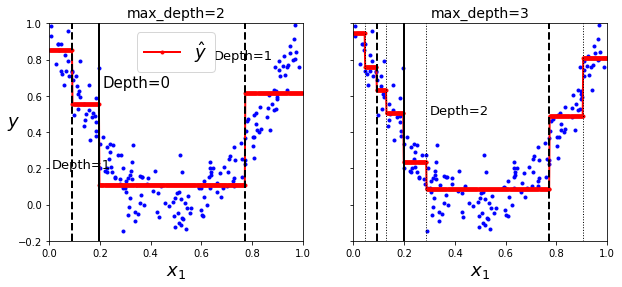

In [11]:
def plot_regression_predictions(tree_reg, X, y, axes=[0, 1, -0.2, 1], ylabel="$y$"):
    x1 = np.linspace(axes[0], axes[1], 500).reshape(-1, 1)
    y_pred = tree_reg.predict(x1)
    plt.axis(axes)
    plt.xlabel("$x_1$", fontsize=18)
    if ylabel:
        plt.ylabel(ylabel, fontsize=18, rotation=0)
    plt.plot(X, y, "b.")
    plt.plot(x1, y_pred, "r.-", linewidth=2, label=r"$\hat{y}$")

fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)
plt.sca(axes[0])
plot_regression_predictions(tree_reg1, X, y)
for split, style in ((0.1973, "k-"), (0.0917, "k--"), (0.7718, "k--")):
    plt.plot([split, split], [-0.2, 1], style, linewidth=2)
plt.text(0.21, 0.65, "Depth=0", fontsize=15)
plt.text(0.01, 0.2, "Depth=1", fontsize=13)
plt.text(0.65, 0.8, "Depth=1", fontsize=13)
plt.legend(loc="upper center", fontsize=18)
plt.title("max_depth=2", fontsize=14)

plt.sca(axes[1])
plot_regression_predictions(tree_reg2, X, y, ylabel=None)
for split, style in ((0.1973, "k-"), (0.0917, "k--"), (0.7718, "k--")):
    plt.plot([split, split], [-0.2, 1], style, linewidth=2)
for split in (0.0458, 0.1298, 0.2873, 0.9040):
    plt.plot([split, split], [-0.2, 1], "k:", linewidth=1)
plt.text(0.3, 0.5, "Depth=2", fontsize=13)
plt.title("max_depth=3", fontsize=14)

plt.show()

In [12]:
from sklearn.tree import export_graphviz

export_graphviz(
        tree_reg1,
        out_file=os.path.join(IMAGES_PATH, "regression_tree.dot"),
        feature_names=["x1"],
        rounded=True,
        filled=True
)

- 回归树每个叶子节点预测的是一个值而不是类别
- 每个叶子节点预测值为该节点包含的样本的平均值
- CART 回归训练流程：
    - 选择的（k, t_k）使得两个子集的加权MSE最小，而不是不纯度
- 由于容易过拟合，它对训练数据中的小变化非常敏感
- 为了避免过拟合，可以设置叶子节点包含最少样本数量